Use neural network to generate PID parameters. Neural network is trained using a model of the plant so we don't need to know jacobian of plant. Model is trained on plant outputs offline.

V3.1 PID neural network takes in previous y value as parameter

V3.2 Take absolute value of Kp, Ki, Kd

V3.3 PID control the plant while training with a manually tuned PID controller

V3.4 Remove 3.3 changes. Initialize bias term with ones

V3.5 Added another layer to model neural network. Initialized only model nn with zeros. Increased NN model size to 16

V3.6 Changed to Adam Optimizer. Increased model to 3 layers: 16, 8 ,4. Added 10 epochs. Lowered learning rate

V3.7 Allowing model nn weight updates in online training

V3.8 Remove 3.7 changes. Added layer to PID nn: 8, 3. Switched to leaky relu in model nn

V3.9 Model hl: 4, 8, 8, 4. PID hl: 8, 5, 3

(V4.0 LSTM didn't show much difference in model learning)

V3.X.0 Split PID neural network into 3 separate networks

V3.X.1 input error into PID neural network. Switched PID to leaky relu. Modified offline training signal to combine sin and square

In [23]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
import tensorflow as tf
from tensorflow.python.framework import ops

In [24]:
d_t = 0.01
d_t_decimal = str(d_t)[::-1].find('.')
steps = 3000

In [25]:
class PID:
    def __init__(self, Kp=0, Ki=0, Kd=0):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.I_max = 5
        self.e = 0
        self.t = 0
        self.e_prev = 0
        self.t_prev = 0
        self.P = 0
        self.I = 0
        self.D = 0
        self.u = 0
        
    def set_state(self, e, t):
        self.e = e
        self.t = t
        
    def update(self, Kp, Ki, Kd):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        
        delta_time = self.t - self.t_prev
        delta_error = self.e - self.e_prev
        
        self.P = e
        
        self.I += e * delta_time

        if (self.I < -self.I_max):
            self.I = -self.I_max
        elif (self.I > self.I_max):
            self.I = self.I_max

        if delta_time > 0:
            self.D = delta_error / delta_time
        else:
            self.D = 0

        self.t_prev = self.t
        self.e_prev = self.e

        self.u = self.Kp * self.P + self.Ki * self.I + self.Kd * self.D
        return np.float32(self.u)
        
    def d_update(self, Kp, Ki, Kd):
        return np.float32(self.P), np.float32(self.I), np.float32(self.D)
    
    def reset(self):
        self.e = 0
        self.t = 0
        self.e_prev = 0
        self.t_prev = 0
        self.P = 0
        self.I = 0
        self.D = 0
        self.u = 0


In [26]:
def plant_process(y, t, u):
    K = 0.01
    tau = 1.0
    T = 0.2
    
    t_delay = round(t-T, d_t_decimal)
    if (t_delay<= 0) or (t_delay<0.0):
        u_delay = u[0]
    else:
        step_t = int(t_delay/d_t)-1
        if step_t >= steps:
            u_delay = u[-1]
        else: 
            u_delay = u[step_t]  
        
    dydt = (-y + K*u_delay)/tau
    return dydt

def plant(y_0, t1, t2, u):
    ts = [t1, t2]
    return odeint(plant_process, y_0, ts, args=(u,))[1]

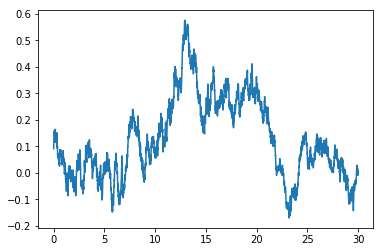

In [33]:
interval = 200
r_steps = steps//interval

r_sq = np.zeros(steps)
up = -1

for i in range(r_steps):
    if i < r_steps-1:
        r_sq[i * interval:(i+1)*interval] = up
    else:
        r_sq[i * interval:] = up
    if up > 0:
        up = -1
    else:
        up = 1

t = np.linspace(0, d_t*steps, steps)
r_sin = np.sin(t)

def gen_rand_sig(t):
    N = 1000
    x = np.random.normal(scale=10.0, size=len(t))
    return np.convolve(x, np.ones((N,))/N)[(N-1):] 
    
r_rand = gen_rand_sig(t)
plt.plot(t, r_rand)

r_combo = np.append(r_sin[:steps//2], r_sq[steps//2:])

### Plant control with neural network

In [42]:
pid = PID()

np_update = np.vectorize(pid.update)
np_d_update = np.vectorize(pid.d_update)

def tf_d_update(Kp, Ki, Kd,name=None):
    with tf.name_scope(name, "d_update", [Kp, Ki, Kd]) as name:
        y = tf.py_func(np_d_update,
                        [Kp, Ki, Kd],
                        (tf.float32, tf.float32, tf.float32),
                        name=name,
                        stateful=False)
        return y

def py_func(func, inp, Tout, stateful=True, name=None, grad=None):

    # Need to generate a unique name to avoid duplicates:
    rnd_name = 'PyFuncGrad' + str(np.random.randint(0, 1E+8))

    tf.RegisterGradient(rnd_name)(grad)  # see _MySquareGrad for grad example
    g = tf.get_default_graph()
    with g.gradient_override_map({"PyFunc": rnd_name}):
        return tf.py_func(func, inp, Tout, stateful=stateful, name=name)
    
def updategrad(op, grad):
    Kp, Ki, Kd = op.inputs
    
    dudKp, dudKi, dudKd = tf_d_update(Kp, Ki, Kd)
    return grad * dudKp, grad * dudKi, grad * dudKd


def tf_update(Kp, Ki, Kd, name=None):

    with tf.name_scope(name, "update", [Kp, Ki, Kd]) as name:
        y = py_func(np_update,
                        [Kp, Ki, Kd],
                        [tf.float32],
                        name=name,
                        grad=updategrad)  # <-- here's the call to the gradient
        return y[0]

hm1 = 2
hm2 = 4
hm3 = 8
hm4 = 16

hpKp1 = 8
hpKi1 = 8
hpKd1 = 8
hpKp2 = 3
hpKi2 = 3
hpKd2 = 3

graph = tf.Graph()
with graph.as_default():
    
    tf_r = tf.placeholder(tf.float32,shape=())
    tf_y = tf.placeholder(tf.float32,shape=())
    tf_e = tf.placeholder(tf.float32,shape=())
    tf_learning_rate = tf.placeholder(tf.float32, shape=())

              
    # Model NN    
    wm_1 = tf.Variable(tf.truncated_normal([1, hm1]))
    bm_1 = tf.Variable(tf.zeros([hm1]))   
    wm_2 = tf.Variable(tf.truncated_normal([hm1, hm2]))
    bm_2 = tf.Variable(tf.zeros([hm2]))
    wm_3 = tf.Variable(tf.truncated_normal([hm2, hm3]))
    bm_3 = tf.Variable(tf.zeros([hm3]))
    wm_4 = tf.Variable(tf.truncated_normal([hm3, hm4]))
    bm_4 = tf.Variable(tf.zeros([hm4]))
    wm_5 = tf.Variable(tf.truncated_normal([hm4, 1]))
    bm_5 = tf.Variable(tf.zeros([1]))
    
    # PID param NN
    wpid_Kp_1 = tf.Variable(tf.truncated_normal([1, hpKp1]))
    bpid_Kp_1 = tf.Variable(tf.ones([hpKp1]))   
    wpid_Kp_2 = tf.Variable(tf.truncated_normal([hpKp1, hpKp2]))
    bpid_Kp_2 = tf.Variable(tf.ones([hpKp2]))
    wpid_Kp_3 = tf.Variable(tf.truncated_normal([hpKp2, 1]))
    bpid_Kp_3 = tf.Variable(tf.ones([1]))
    
    wpid_Ki_1 = tf.Variable(tf.truncated_normal([1, hpKi1]))
    bpid_Ki_1 = tf.Variable(tf.ones([hpKi1]))   
    wpid_Ki_2 = tf.Variable(tf.truncated_normal([hpKi1, hpKi2]))
    bpid_Ki_2 = tf.Variable(tf.ones([hpKi2]))
    wpid_Ki_3 = tf.Variable(tf.truncated_normal([hpKi2, 1]))
    bpid_Ki_3 = tf.Variable(tf.ones([1]))
    
    wpid_Kd_1 = tf.Variable(tf.truncated_normal([1, hpKd1]))
    bpid_Kd_1 = tf.Variable(tf.ones([hpKd1]))   
    wpid_Kd_2 = tf.Variable(tf.truncated_normal([hpKd1, hpKd2]))
    bpid_Kd_2 = tf.Variable(tf.ones([hpKd2]))
    wpid_Kd_3 = tf.Variable(tf.truncated_normal([hpKd2, 1]))
    bpid_Kd_3 = tf.Variable(tf.ones([1]))

    def model_fp(input_value):
        z1 = tf.matmul(input_value, wm_1) + bm_1
        a1 = tf.nn.leaky_relu(z1)
        
        z2 = tf.matmul(a1, wm_2) + bm_2
        a2 = tf.nn.leaky_relu(z2)
        
        z3 = tf.matmul(a2, wm_3) + bm_3
        a3 = tf.nn.leaky_relu(z3)
        
        z4 = tf.matmul(a3, wm_4) + bm_4
        a4 = tf.nn.leaky_relu(z4)
        
        return tf.matmul(a4, wm_5) + bm_5
        
    
    # Forward prop model offline
    y_model_offline = model_fp(tf.reshape(tf_r, (1, 1)))
 
    def pid_fp(input_value, w1, b1, w2, b2, w3, b3):
        z1 = tf.matmul(input_value, w1) + b1
        a1 = tf.nn.leaky_relu(z1)
        z2 = tf.matmul(a1, w2) + b2
        a2 = tf.nn.leaky_relu(z2)
        return tf.matmul(a2, w3) + b3
    
    # Forward prop PID
    e_rs = tf.reshape(tf_e, (1, 1))
    
    Kp = pid_fp(e_rs, wpid_Kp_1, bpid_Kp_1, wpid_Kp_2, bpid_Kp_2, wpid_Kp_3, bpid_Kp_3)
    Ki = pid_fp(e_rs, wpid_Ki_1, bpid_Ki_1, wpid_Ki_2, bpid_Ki_2, wpid_Ki_3, bpid_Ki_3)
    Kd = pid_fp(e_rs, wpid_Kd_1, bpid_Kd_1, wpid_Kd_2, bpid_Kd_2, wpid_Kd_3, bpid_Kd_3)
    
    Kp_abs = tf.math.abs(Kp)
    Ki_abs = tf.math.abs(Ki)
    Kd_abs = tf.math.abs(Kd)
    
    u_nn = tf_update(Kp_abs, Ki_abs, Kd_abs)
#     u_nn = tf_update(Kp, Ki, Kd)
    
    # Forward prop model online
    y_model_online = model_fp(u_nn)

    
    model_var_list = [wm_1, bm_1, wm_2, bm_2, wm_3, bm_3, wm_4, bm_4, wm_5, bm_5]
    model_loss = tf.losses.mean_squared_error(tf_y, tf.reshape(y_model_offline, ()))
    model_opt = tf.train.AdamOptimizer(tf_learning_rate).minimize(model_loss, var_list=model_var_list)

    pid_var_list = [wpid_Kp_1, bpid_Kp_1, wpid_Kp_2, bpid_Kp_2, wpid_Kp_3, bpid_Kp_3,
                   wpid_Ki_1, bpid_Ki_1, wpid_Ki_2, bpid_Ki_2, wpid_Ki_3, bpid_Ki_3,
                   wpid_Kd_1, bpid_Kd_1, wpid_Kd_2, bpid_Kd_2, wpid_Kd_3, bpid_Kd_3]
    pid_loss = tf.losses.mean_squared_error(tf_r, tf.reshape(y_model_online, ()))
    pid_opt = tf.train.AdamOptimizer(tf_learning_rate).minimize(pid_loss, var_list=pid_var_list)


In [43]:
epochs = 10

y_0 = 0
y_p_offline = np.zeros(steps)
y_m_offline = np.zeros(steps)

y_p_online = np.zeros(steps)
y_m_online = np.zeros(steps)
u_offline = np.zeros(steps)
u_online = np.zeros(steps)

Kp = np.zeros(steps)
Ki = np.zeros(steps)
Kd = np.zeros(steps)

offline_loss = np.zeros(steps * epochs)
online_loss = np.zeros(steps * epochs) 

def reset_offline():
    pid.reset()
    y_0 = 0
    
    y_p_offline = np.zeros(steps)
    y_m_offline = np.zeros(steps)
    u_offline = np.zeros(steps)


def reset_online():
    pid.reset()
    y_0 = 0
    
    y_p_online = np.zeros(steps)
    y_m_online = np.zeros(steps)
    u_online = np.zeros(steps)


r_offline = r_combo
r_online = r_sq


offline_lr = 0.01
online_lr = 0.01

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for j in range(epochs):
        reset_offline()
        print("Start epoch", j)
        for i in range(steps)[1:]:
            t_prev = t[i-1]
            t_cur = t[i]

            # Get plant output
            y_p_offline[i] = plant(y_0, t_prev, t_cur, r_offline)
            # Train model on plant output
            feed_dict = {tf_y:y_p_offline[i], tf_r:r_offline[i], tf_learning_rate:offline_lr}
            _, offline_loss[i + j*steps], y_m_offline[i] = session.run([model_opt, model_loss, y_model_offline], 
                                                             feed_dict=feed_dict)

            y_0 = y_p_offline[i]
            
        print("Offline loss", sum(offline_loss[:i + j*steps])/(i + j*steps))

        reset_online()
        for i in range(steps)[1:]:  

            e = r_online[i] - y_p_online[i-1]
            t_prev = t[i-1]
            t_cur = t[i]
            pid.set_state(e, t_cur)

            # Get get PID parameters and get control signal
            # Send to model to train PID param NN
            feed_dict = {tf_e:e, tf_r:r_online[i], tf_learning_rate:online_lr}
            _, online_loss[i + j*steps], y_m_online[i], u_online[i] = session.run([pid_opt, pid_loss, y_model_online, u_nn], 
                                                    feed_dict=feed_dict)
            y_p_online[i] = plant(y_0, t_prev, t_cur, u_online)
            y_0 = y_p_online[i]
            
        print("Online loss", sum(online_loss[:i + j*steps])/(i + j*steps))

    #Test
    reset_online()
    for i in range(len(t))[1:]:  
        
        e = r_online[i] - y_p_online[i-1]
        t_prev = t[i-1]
        t_cur = t[i]
        pid.set_state(e, t_cur)
        
        # Get get PID parameters and get control signal
        # Send to model to train PID param NN
        feed_dict = {tf_e:e, tf_r:r_online[i], tf_learning_rate:online_lr}
        y_m_online[i], u_online[i] = session.run([y_model_online, u_nn], feed_dict=feed_dict)
        Kp[i] = pid.Kp
        Ki[i] = pid.Ki
        Kd[i] = pid.Kd
        
        y_p_online[i] = plant(y_0, t_prev, t_cur, u_online)
        y_0 = y_p_online[i]

Start epoch 0
Offline loss 4.839531997637662e-05
Online loss 0.4271475786647671
Start epoch 1
Offline loss 3.061385252865743e-05
Online loss 0.6157307572874575
Start epoch 2
Offline loss 2.1643693673450318e-05
Online loss 0.7168519583103606
Start epoch 3
Offline loss 1.6658273981025427e-05
Online loss 0.8629722154412621
Start epoch 4
Offline loss 1.6082907036327533e-05
Online loss 0.9698403004811915
Start epoch 5
Offline loss 1.3502155465695148e-05
Online loss 0.8956624500959179
Start epoch 6
Offline loss 1.171355113036141e-05
Online loss 0.842799115401479
Start epoch 7
Offline loss 1.0373202187667788e-05
Online loss 0.7812168782725879
Start epoch 8
Offline loss 1.0505178834078194e-05
Online loss 0.7578917672396791
Start epoch 9
Offline loss 9.876290776775227e-06
Online loss 0.7370868676743733


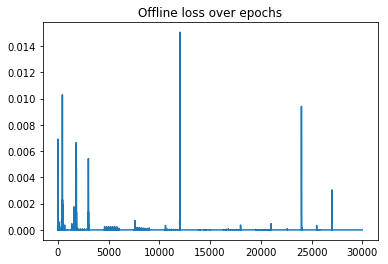

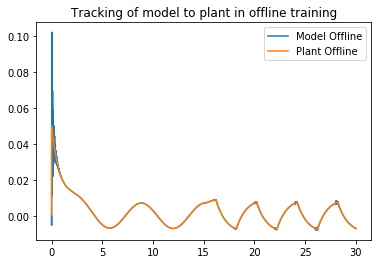

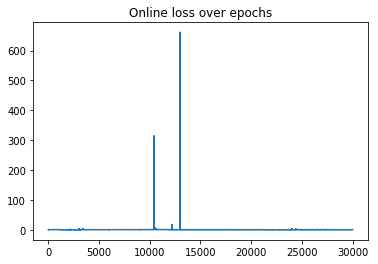

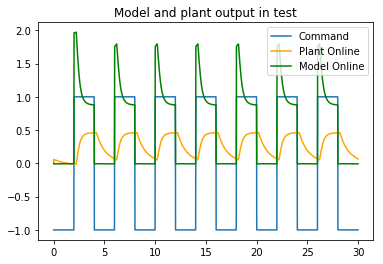

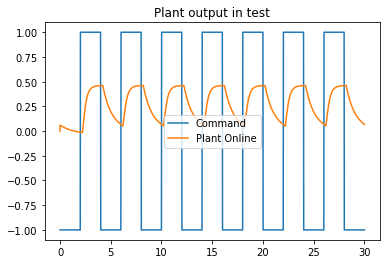

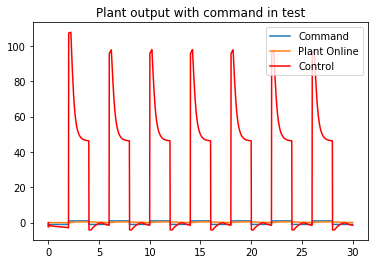

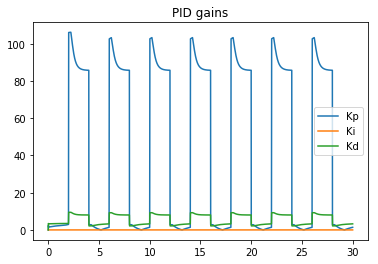

In [44]:
plt.plot(offline_loss)
plt.title('Offline loss over epochs')
plt.show()

plt.plot(t, y_m_offline)
plt.plot(t, y_p_offline)
plt.title('Tracking of model to plant in offline training')
plt.legend(('Model Offline', 'Plant Offline'))
plt.show()

plt.plot(online_loss)
plt.title('Online loss over epochs')
plt.show()

plt.plot(t, r_sq)
plt.plot(t, y_p_online, color='orange')
plt.plot(t, y_m_online, color='green')
plt.title('Model and plant output in test')
plt.legend(('Command', 'Plant Online', 'Model Online'))
plt.show()

plt.plot(t, r_sq)
plt.plot(t, y_p_online)
plt.title('Plant output in test')
plt.legend(('Command', 'Plant Online'))
plt.show()

plt.plot(t, r_sq)
plt.plot(t, y_p_online)
plt.plot(t, u_online, color='red')
plt.title('Plant output with command in test')
plt.legend(('Command', 'Plant Online', 'Control'))
plt.show()

plt.plot(t, Kp)
plt.plot(t, Ki)
plt.plot(t, Kd)
plt.title('PID gains')
plt.legend(('Kp', 'Ki', 'Kd'))
plt.show()